Prio_gird shape file at https://www.prio.org/Data/PRIO-GRID/ or dirrectly from file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip  
Prio variables from http://grid.prio.org/#/download  

UCDP shapefile from https://www.ucdp.uu.se/downloads/#d1 or directly from http://ucdp.uu.se/downloads/ged/ged181-shp.zip
But it seem you just need the CSV: https://www.ucdp.uu.se/downloads/#d1 or directly from http://ucdp.uu.se/downloads/ged/ged181-csv.zip

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
def import_df():
    """Function for loading, handling and merging the data. Rigth now you don't use the prio gird thou.."""
    #t1 = time.time()
    
    # load data:
    prio_grid = gpd.read_file("zip://data/priogrid_shapefiles.zip")
    ucdp = pd.read_csv("data/ged181-csv.zip")# the error is not importent as you do not use that feature. Seems to take zip files just fine.
    prio_cshape_codes = pd.read_csv("data/PRIO-GRID Yearly Variables for 1989-2014 - 2019-02-12.csv")
    
    # Merging prio
    prio_full = pd.merge(prio_grid, prio_cshape_codes, how='inner', on = ['gid'])
    
    # updating prio grid years (could you not just use interpolate forward?)
    diff = ucdp['year'].max() - prio_full['year'].max()
    
    list_sub = []

    for i in range(1, diff + 1):
        subset = prio_full[prio_full['year'] == prio_full['year'].max()].copy()
        subset['year'] = prio_full['year'].max() + i

        list_sub.append(subset)

    updated_years = pd.concat(list_sub)
    prio_full_updated = pd.concat([prio_full, updated_years])
    
    # removing inter state conflicts:
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between two states
    
    # Choosing the features to use from UCDP:
    ucdp_lean = ucdp[['priogrid_gid','year','best']]
    
    # Aggregating yearly fatalities in UCDP:
    ucdp_lean_agg = ucdp_lean.groupby(by=['priogrid_gid','year']).sum().reset_index() # works fine
    
    # Remaning to fit PRIO
    ucdp_lean_agg.rename(columns={'priogrid_gid':'gid'}, inplace=True)
    ucdp_lean_agg.rename(columns={'country_id':'gwno'}, inplace=True)
    
    # Merging
    prio_ucdp_full =  pd.merge(prio_full_updated, ucdp_lean_agg, how = 'outer', on = ['gid','year']) # try how = 'left' if problems.
    
    # Filling in cells with non-fatalities.
    prio_ucdp_full['best'].fillna(value=0, inplace = True)
    
    # log best for plotting:
    prio_ucdp_full['log_best'] = np.log(prio_ucdp_full['best'] + 1)
    
    # dropping nans
    prio_ucdp_full.dropna(inplace = True)
    
    return(prio_ucdp_full)
    

In [3]:
df = import_df()

/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Visual test

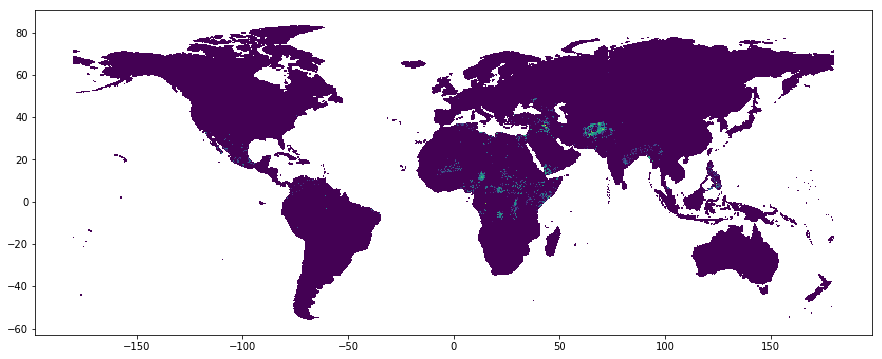

In [4]:
df[df['year']==2017].plot(column = 'log_best', figsize=(15, 15))
plt.show()

# save the data as a pickle

In [5]:
import pickle

In [6]:
file_name = "full_df.pkl"
output = open(file_name, 'wb') # still not working right!!
pickle.dump(df, output)
output.close()

### test the pickle:

In [7]:
pkl_file = open('full_df.pkl', 'rb')

pickle_test_gdf = pickle.load(pkl_file)

pkl_file.close()


In [8]:
pickle_test_gdf.shape

(1879707, 10)

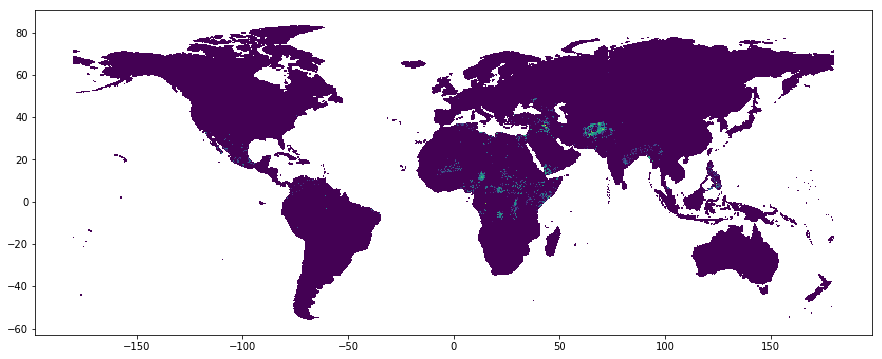

In [9]:
pickle_test_gdf[pickle_test_gdf['year']==2017].plot(column = 'log_best', figsize=(15, 15))
plt.show()